In [14]:
import numpy as np
import re
from typing import List, Dict
import math
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import statistics

object_title = "Cordless drill"
object_name = "drill"

In [2]:
# Define a data structure to hold the parsed information
class CandidateView:
    def __init__(self, d, num_seen_unknown_vox, num_frustum_surface_vox, num_seen_surface_vox, cam_pose, centroid, distance_to_centroid, distance_to_pose):
        self.d = d
        self.num_seen_unknown_vox = num_seen_unknown_vox
        self.num_frustum_surface_vox = num_frustum_surface_vox
        self.num_seen_surface_vox = num_seen_surface_vox
        self.cam_pose = cam_pose
        self.centroid = centroid
        self.distance_to_centroid = distance_to_centroid
        self.distance_to_pose = distance_to_pose

    def __repr__(self):
        return f"CandidateView(d={self.d}, num_seen_unknown_vox={self.num_seen_unknown_vox}, num_frustum_surface_vox={self.num_frustum_surface_vox}, num_seen_surface_vox={self.num_seen_surface_vox}, cam_pose={self.cam_pose}, centroid={self.centroid}, distance_to_centroid={self.distance_to_centroid}, distance_to_pose={self.distance_to_pose})"

class Position:
    def __init__(self, pose, num_frontiers=-1, num_frontier_vox=-1, eval=-1, max_candidate=None, num_surface_vox=-1, num_unknown=-1, time_loop=-1):
        self.pose = pose
        self.num_frontiers = num_frontiers
        self.num_frontier_vox = num_frontier_vox
        self.eval = eval
        self.max_candidate = max_candidate
        self.num_surface_vox = num_surface_vox
        self.num_unknown = num_unknown
        self.time_loop = time_loop



    def __repr__(self):
      if self.max_candidate is not None:
        return f"Position: (pose={self.pose}, num_frontiers={self.num_frontiers}, num_frontier_vox={self.num_frontier_vox}, eval={self.eval}, max_candidate={self.max_candidate}, num_surface_vox={self.num_surface_vox}, num_unknown={self.num_unknown}, time_loop={self.time_loop})"
      elif self.time_loop != -1:
        return f"Position: (pose={self.pose}, time_loop={self.time_loop}, num_surface_vox={self.num_surface_vox})"
      else:
        return f"Position: (pose={self.pose})"


class Pose:
    def __init__(self, position, orientation):
        self.position = position
        self.orientation = orientation

    def __repr__(self):
        return f"Pose(position={self.position}, orientation={self.orientation})"

class Point:
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z

    def __repr__(self):
        return f"Point(x={self.x}, y={self.y}, z={self.z})"

class Quaternion:
    def __init__(self, x, y, z, w):
        self.x = x
        self.y = y
        self.z = z
        self.w = w

    def __repr__(self):
        return f"Quaternion(x={self.x}, y={self.y}, z={self.z}, w={self.w})"

class Centroid:
    def __init__(self, num_voxels, pos):
        self.num_voxels = num_voxels
        self.pos = pos

    def __repr__(self):
        return f"Centroid(num_voxels={self.num_voxels}, pos={self.pos})"

def parse_line(line: str) -> CandidateView:
    # Regular expressions to extract the data
    d_pattern = r"d=([\d\.]+)"
    num_seen_unknown_vox_pattern = r"num_seen_unknown_vox=(\d+)"
    num_frustum_surface_vox_pattern = r"num_frustum_surface_vox=(\d+)"
    num_seen_surface_vox_pattern = r"num_seen_surface_vox=(\d+)"

    #cam_pose_pattern = r"cam_pose=geometry_msgs\.msg\.Pose\(position=geometry_msgs\.msg\.Point\(x=([\d\.\-]+), y=([\d\.\-]+), z=([\d\.\-]+)\), orientation=geometry_msgs\.msg\.Quaternion\(x=([\d\.\-]+), y=([\d\.\-]+), z=([\d\.\-]+), w=([\d\.\-]+)\)\)"
    cam_pose_pattern = r"cam_pose=geometry_msgs\.msg\.Pose\(position=geometry_msgs\.msg\.Point\(x=([\d\.\-e]+), y=([\d\.\-e]+), z=([\d\.\-e]+)\), orientation=geometry_msgs\.msg\.Quaternion\(x=([\d\.\-e]+), y=([\d\.\-e]+), z=([\d\.\-e]+), w=([\d\.\-e]+)\)\)"

    centroid_pattern = r"centroid=nbv_interfaces\.msg\.Centroid\(num_voxels=(\d+), pos=geometry_msgs\.msg\.Point\(x=([\d\.\-]+), y=([\d\.\-]+), z=([\d\.\-]+)\)\)"
    distance_to_centroid_pattern = r"Distance to centroid: ([\d\.]+)"
    distance_to_pose_pattern = r"Distance to pose: ([\d\.]+)"

    d = float(re.search(d_pattern, line).group(1))
    num_seen_unknown_vox = int(re.search(num_seen_unknown_vox_pattern, line).group(1))
    num_frustum_surface_vox = int(re.search(num_frustum_surface_vox_pattern, line).group(1))
    num_seen_surface_vox = int(re.search(num_seen_surface_vox_pattern, line).group(1))

    cam_pose_match = re.search(cam_pose_pattern, line)
    cam_pose_position = Point(float(cam_pose_match.group(1)), float(cam_pose_match.group(2)), float(cam_pose_match.group(3)))
    cam_pose_orientation = Quaternion(float(cam_pose_match.group(4)), float(cam_pose_match.group(5)), float(cam_pose_match.group(6)), float(cam_pose_match.group(7)))
    cam_pose = Pose(cam_pose_position, cam_pose_orientation)

    centroid_match = re.search(centroid_pattern, line)
    centroid_pos = Point(float(centroid_match.group(2)), float(centroid_match.group(3)), float(centroid_match.group(4)))
    centroid = Centroid(int(centroid_match.group(1)), centroid_pos)

    distance_to_centroid_match = re.search(distance_to_centroid_pattern, line)
    if distance_to_centroid_match is None:
      distance_to_centroid = -1
    else:
      distance_to_centroid = float(distance_to_centroid_match.group(1))
    distance_to_pose_match = re.search(distance_to_pose_pattern, line)
    if distance_to_pose_match is None:
      distance_to_pose = -1
    else:
      distance_to_pose = float(distance_to_pose_match.group(1))

    return CandidateView(d, num_seen_unknown_vox, num_frustum_surface_vox, num_seen_surface_vox, cam_pose, centroid, distance_to_centroid, distance_to_pose)

def parse_metric_line(line: str) -> Position:
    candidate_pattern=r"nbv_interfaces\.msg\.CandidateView\((.*?)\)\)\)"
    num_frontiers_pattern = r"num frontiers: (\d+)"
    num_frontier_vox_pattern = r"num frontier voxel: (\d+)"
    eval_pattern = r"eval ([\d\.]+)"
    num_surface_voxel_pattern = r"num surface voxel (\d+)"
    num_unknown_pattern = r"(?:num unknown|max vuv) \s*(\d+)"
    time_loop_pattern = r"Time for loop: ([\d\.]+)"
    pose_pattern = r"Position: geometry_msgs\.msg\.Pose\(position=geometry_msgs\.msg\.Point\(x=([\d\.\-eE]+), y=([\d\.\-e]+), z=([\d\.\-e]+)\), orientation=geometry_msgs\.msg\.Quaternion\(x=([\d\.\-e]+), y=([\d\.\-e]+), z=([\d\.\-e]+), w=([\d\.\-e]+)\)\)"


    cam_pose_match = re.search(pose_pattern, line)
    if cam_pose_match is None:
      return None
    cam_pose_position = Point(float(cam_pose_match.group(1)), float(cam_pose_match.group(2)), float(cam_pose_match.group(3)))
    cam_pose_orientation = Quaternion(float(cam_pose_match.group(4)), float(cam_pose_match.group(5)), float(cam_pose_match.group(6)), float(cam_pose_match.group(7)))
    cam_pose = Pose(cam_pose_position, cam_pose_orientation)

    time_loop_match = re.search(time_loop_pattern, line)
    if time_loop_match is None:
      return Position(cam_pose)
    time_loop = float(time_loop_match.group(1))
    num_surface_vox = int(re.search(num_surface_voxel_pattern, line).group(1))
    candidate_str = re.search(candidate_pattern, line)

    if candidate_str is None:
        return Position(cam_pose, time_loop=time_loop, num_surface_vox=num_surface_vox)
    #print(candidate_str.group(1) + '))')
    candidate = parse_line(candidate_str.group(1) + '))')

    num_frontiers = int(re.search(num_frontiers_pattern, line).group(1))
    num_frontier_vox = int(re.search(num_frontier_vox_pattern, line).group(1))
    eval = float(re.search(eval_pattern, line).group(1))
    num_surface_vox = int(re.search(num_surface_voxel_pattern, line).group(1))
    num_unknown = int(re.search(num_unknown_pattern, line).group(1))

    return Position(cam_pose, num_frontiers, num_frontier_vox, eval, candidate, num_surface_vox, num_unknown, time_loop)




def read_data(file_path: str) -> List[CandidateView]:
    candidate_views = []
    with open(file_path, 'r') as file:
        for line in file:
            candidate_view = parse_line(line)
            candidate_views.append(candidate_view)
    return candidate_views

def read_metrics_data(file_path: str) -> List[Position]:
    positions = []
    time_total = 0
    with open(file_path, 'r') as file:
        for line in file:
            position = parse_metric_line(line)
            if position is not None:
              positions.append(position)
            else:
              total_time_pattern = r"Total time: ([\d\.]+)"
              time_total = float(re.search(total_time_pattern, line).group(1))
    return positions, time_total

In [3]:

def quaternion_to_euler_2(q: Quaternion):
  return quaternion_to_euler(q.w, q.x, q.y, q.z)

def quaternion_to_euler(w, x, y, z):
    roll = np.arctan2(2 * (w * x + y * z), 1 - 2 * (x**2 + y**2))
    pitch = -math.pi * 0.5 + 2 * np.arctan2(np.sqrt(1 + 2 * (w * y - x * z)), np.sqrt(1 - 2 * (w * y - x * z)))
    yaw = np.arctan2(2 * (w * z + x * y), 1 - 2 * (y**2 + z**2))
    return roll, pitch, yaw

def is_right(q1: Quaternion, q2: Quaternion):
  r1,p1,y1 = quaternion_to_euler(q1.w, q1.x, q1.y, q1.z)
  r2,p2,y2 = quaternion_to_euler(q2.w, q2.x, q2.y, q2.z)
  return (y2 - y1 < 0)


In [4]:
def quaternion_to_rotation_matrix(q: Quaternion):
    quaternion = [q.x, q.y, q.z, q.w]
    r = R.from_quat(quaternion)
    return r.as_matrix()

def is_left(pose1: Pose, pose2: Pose):
    position1 = [pose1.position.x, pose1.position.y, pose1.position.z]
    orientation1 = [pose1.orientation.x, pose1.orientation.y, pose1.orientation.z, pose1.orientation.w]
    position2 = [pose2.position.x, pose2.position.y, pose2.position.z]
    orientation2 = [pose2.orientation.x, pose2.orientation.y, pose2.orientation.z, pose2.orientation.w]

    # Convert orientation1 to rotation matrix
    R1 = quaternion_to_rotation_matrix(pose1.orientation)

    # Convert orientation2 to rotation matrix
    R2 = quaternion_to_rotation_matrix(pose2.orientation)

    # Compute relative position
    relative_position = np.array(position2) - np.array(position1)

    # Transform relative position to local frame of pose1
    local_relative_position = R1.T @ relative_position

    # Check if the y-component is positive
    return local_relative_position[1] > 0

def angle(pose1: Pose, pose2: Pose) -> float:
    position1 = [pose1.position.x, pose1.position.y, pose1.position.z]
    position2 = [pose2.position.x, pose2.position.y, pose2.position.z]
    centroid = [candidates[0].centroid.pos.x, candidates[0].centroid.pos.y, candidates[0].centroid.pos.z]
    rel_pos1 = np.array(position1) - np.array(centroid)
    rel_pos2 = np.array(position2) - np.array(centroid)
    return np.arccos(np.dot(rel_pos1, rel_pos2) / (np.linalg.norm(rel_pos1) * np.linalg.norm(rel_pos2)))

def rad_to_deg(rad):
    return rad * 180 / math.pi

In [5]:
object_dict = {}

for o in ["box", "bunny", "crate", "drill"]:
  path_to_metrics = f"{o}" 
  metrics_0_unknown, total_0_unknown = read_metrics_data(os.path.join(path_to_metrics, "unknown_0", "metrics_0_unknown.txt"))
  metrics_0_vuv, total_0_vuv = read_metrics_data(os.path.join(path_to_metrics,"vuv_0","metrics_0_vuv.txt"))
  metrics_1_unknown, total_1_unknown = read_metrics_data(os.path.join(path_to_metrics,"unknown_1","metrics_1_unknown.txt"))
  metrics_1_vuv, total_1_vuv = read_metrics_data(os.path.join(path_to_metrics,"vuv_1","metrics_1_vuv.txt"))
  metrics_2_unknown, total_2_unknown = read_metrics_data(os.path.join(path_to_metrics,"unknown_2","metrics_2_unknown.txt"))
  metrics_2_vuv, total_2_vuv = read_metrics_data(os.path.join(path_to_metrics,"vuv_2","metrics_2_vuv.txt"))
  d = {"0" : {"unknown" : (metrics_0_unknown, total_0_unknown), "vuv": (metrics_0_vuv, total_0_vuv)},
          "1": {"unknown": (metrics_1_unknown, total_1_unknown), "vuv": (metrics_1_vuv, total_1_vuv)},
          "2": {"unknown": (metrics_2_unknown, total_2_unknown), "vuv": (metrics_2_vuv, total_2_vuv)}}
  object_dict[o] = d

In [160]:
first_pos = object_dict[object_name]["1"]["unknown"][0][0]
number="first"
pose = first_pos.pose
num_heuristic = first_pos.num_unknown
num_occupied = first_pos.num_surface_vox
num_frontier_vox = first_pos.num_frontier_vox
candidates = read_data(f"{object_name}/unknown_1/candidates_0_1_unknown.txt")
candidates = sorted(candidates, key= lambda x : (x.distance_to_centroid, x.distance_to_pose))
part_of = lambda x, rest : round(x.distance_to_centroid, 4) == round(rest[0].distance_to_centroid, 4)
close = [x for x in candidates if part_of(x, candidates)]
rest = [x for x in candidates if not part_of(x, candidates)]

mid = [x for x in rest if part_of(x, rest)]
rest = [x for x in rest if not part_of(x, rest)]
far = [x for x in rest if part_of(x, rest)] 



In [143]:
m = object_dict[object_name]["1"]["unknown"][0]
number='last'
last_pos = [p for p in m if p.time_loop != -1][-1]
pose = last_pos.pose
num_heuristic = last_pos.num_unknown
num_occupied = last_pos.num_surface_vox
num_frontier_vox = last_pos.num_frontier_vox
candidates = read_data(f"{object_name}/unknown_1/candidates_{len([p for p in m if p.time_loop != -1]) - 1}_1_unknown.txt")
candidates = sorted(candidates, key= lambda x : (x.distance_to_centroid, x.distance_to_pose))
part_of = lambda x, rest : round(x.distance_to_centroid, 4) == round(rest[0].distance_to_centroid, 4)
close = [x for x in candidates if part_of(x, candidates)]
rest = [x for x in candidates if not part_of(x, candidates)]

mid = [x for x in rest if part_of(x, rest)]
rest = [x for x in rest if not part_of(x, rest)]
far = [x for x in rest if part_of(x, rest)] 

In [161]:
### Mid
X_dist_mid = [ -c.distance_to_pose if is_left(c.cam_pose, pose) else c.distance_to_pose for c in mid]
X_dist_mid.append(0.0)

X_mid = [ -rad_to_deg(angle(c.cam_pose, pose)) if is_left(c.cam_pose, pose) else rad_to_deg(angle(c.cam_pose,pose)) for c in mid]
X_mid.append(0.0)


### Close
X_dist_close = [ -c.distance_to_pose if is_left(c.cam_pose, pose) else c.distance_to_pose for c in close]
X_dist_close.append(0.0)

X_close = [ -rad_to_deg(angle(c.cam_pose, pose)) if is_left(c.cam_pose, pose) else rad_to_deg(angle(c.cam_pose,pose)) for c in close]
X_close.append(0.0)


### Far
X_dist_far = [ -c.distance_to_pose if is_left(c.cam_pose, pose) else c.distance_to_pose for c in far]
X_dist_far.append(0.0)

X_far = [ -rad_to_deg(angle(c.cam_pose, pose)) if is_left(c.cam_pose, pose) else rad_to_deg(angle(c.cam_pose,pose)) for c in far]
X_far.append(0.0)

print(X_far)

[-21.8933242373302, 21.89332423733019, -43.6845162665452, 43.68451626654522, -65.37201381841598, 65.37201381841598, -86.83582739744234, 86.83582739744234, 0.0]


In [162]:
Y_d_mid = [1.0 / (1.0 + c.d) for c in mid]
Y_d_close = [1.0 / (1.0 + c.d) for c in close]
Y_d_far = [1.0 / (1.0 + c.d) for c in far]
Y_d_mid.append(1.0)
Y_d_close.append(1.0)
Y_d_far.append(1.0)

### mid
sorted_list = sorted(zip(X_mid,Y_d_mid), key=lambda x : x[0])
positions_d_mid = np.array([x_val for (x_val, y_val) in sorted_list])
d_factors_mid = np.array([y_val for (x_val, y_val) in  sorted_list])

sorted_dist_list = sorted(zip(X_dist_mid,Y_d_mid), key=lambda x : x[0])
positions_dist_d_mid = np.array([x_val for (x_val, y_val) in sorted_dist_list])

### close
sorted_list = sorted(zip(X_close,Y_d_close), key=lambda x : x[0])
positions_d_close = np.array([x_val for (x_val, y_val) in sorted_list])
d_factors_close = np.array([y_val for (x_val, y_val) in  sorted_list])

sorted_dist_list = sorted(zip(X_dist_close,Y_d_far), key=lambda x : x[0])
positions_dist_d_close = np.array([x_val for (x_val, y_val) in sorted_dist_list])

###far
sorted_list = sorted(zip(X_far,Y_d_far), key=lambda x : x[0])
positions_d_far = np.array([x_val for (x_val, y_val) in sorted_list])
d_factors_far = np.array([y_val for (x_val, y_val) in  sorted_list])

sorted_dist_list = sorted(zip(X_dist_far,Y_d_far), key=lambda x : x[0])
positions_dist_d_far = np.array([x_val for (x_val, y_val) in sorted_dist_list])

In [163]:
Y_ig_mid = [c.num_seen_unknown_vox / (1.0 + num_heuristic) for c in mid]
Y_ig_mid.append(0.0)

Y_ig_close = [c.num_seen_unknown_vox / (1.0 + num_heuristic) for c in close]
Y_ig_close.append(0.0)

Y_ig_far = [c.num_seen_unknown_vox / (1.0 + num_heuristic) for c in far]
Y_ig_far.append(0.0)

### mid
sorted_list = sorted(zip(X_mid,Y_ig_mid), key=lambda x : x[0])
positions_ig_mid = np.array([x_val for (x_val, y_val) in sorted_list])
ig_factors_mid = np.array([y_val for (x_val, y_val) in  sorted_list])

### close
sorted_list = sorted(zip(X_close,Y_ig_close), key=lambda x : x[0])
positions_ig_close = np.array([x_val for (x_val, y_val) in sorted_list])
ig_factors_close = np.array([y_val for (x_val, y_val) in  sorted_list])

sorted_list = sorted(zip(X_far,Y_ig_far), key=lambda x : x[0])
positions_ig_far = np.array([x_val for (x_val, y_val) in sorted_list])
ig_factors_far = np.array([y_val for (x_val, y_val) in  sorted_list])

In [164]:
o_perc = lambda x : (num_occupied - x.num_frustum_surface_vox) / num_occupied * 100
o_factor = lambda o: 1.0 / (1.0 + o_perc(o))

### Mid
Y_o_mid = [o_factor(c) for c in mid]
#X_o = [ -c.distance_to_pose if is_left(c.cam_pose, pose) else c.distance_to_pose for c in candidates]
X_o = [ -rad_to_deg(angle(c.cam_pose, pose)) if is_left(c.cam_pose, pose) else rad_to_deg(angle(c.cam_pose,pose)) for c in mid]
Y_o_mid.append(1.0)
X_o.append(0.0)

sorted_list = sorted(zip(X_o,Y_o_mid), key=lambda x : x[0])
positions_o_mid = np.array([x_val for (x_val, y_val) in sorted_list])
o_factors_mid = np.array([y_val for (x_val, y_val) in  sorted_list])

### Close
Y_o_close = [o_factor(c) for c in close]
X_o = [ -rad_to_deg(angle(c.cam_pose, pose)) if is_left(c.cam_pose, pose) else rad_to_deg(angle(c.cam_pose,pose)) for c in close]
Y_o_close.append(1.0)
X_o.append(0.0)

sorted_list = sorted(zip(X_o,Y_o_close), key=lambda x : x[0])
positions_o_close = np.array([x_val for (x_val, y_val) in sorted_list])
o_factors_close = np.array([y_val for (x_val, y_val) in  sorted_list])


### Far
Y_o_far = [o_factor(c) for c in far]
X_o = [ -rad_to_deg(angle(c.cam_pose, pose)) if is_left(c.cam_pose, pose) else rad_to_deg(angle(c.cam_pose,pose)) for c in far]
Y_o_far.append(1.0)
X_o.append(0.0)

sorted_list = sorted(zip(X_o,Y_o_far), key=lambda x : x[0])
positions_o_far = np.array([x_val for (x_val, y_val) in sorted_list])
o_factors_far = np.array([y_val for (x_val, y_val) in  sorted_list])

In [165]:
Y_f_mid = [c.centroid.num_voxels / num_frontier_vox for c in mid]
Y_f_mid.append(Y_f_mid[0])

Y_f_close = [c.centroid.num_voxels / num_frontier_vox for c in close]
Y_f_close.append(Y_f_close[0])

Y_f_far = [c.centroid.num_voxels / num_frontier_vox for c in far]
Y_f_far.append(Y_f_far[0])


### mid
#utility_mid = lambda i : statistics.harmonic_mean([Y_f_mid[i], Y_d_mid[i], Y_ig_mid[i], Y_o_mid[i]])
utility_mid = lambda i : Y_f_mid[i] * Y_d_mid[i] * Y_ig_mid[i] * Y_o_mid[i]

Y_eval_mid = [utility_mid(i) for i in range(len(Y_f_mid))]
sorted_list = sorted(zip(X_mid,Y_eval_mid), key=lambda x : x[0])
positions_eval_mid = np.array([x_val for (x_val, y_val) in sorted_list])
eval_factors_mid = np.array([y_val for (x_val, y_val) in  sorted_list])

### close
#utility_close = lambda i : statistics.harmonic_mean([Y_f_close[i], Y_d_close[i], Y_ig_close[i], Y_o_close[i]])
utility_close = lambda i : Y_f_close[i] * Y_d_close[i] * Y_ig_close[i] * Y_o_close[i]

Y_eval_close = [utility_close(i) for i in range(len(Y_f_close))]
sorted_list = sorted(zip(X_close,Y_eval_close), key=lambda x : x[0])
positions_eval_close = np.array([x_val for (x_val, y_val) in sorted_list])
eval_factors_close = np.array([y_val for (x_val, y_val) in  sorted_list])

### far
#utility_far = lambda i : statistics.harmonic_mean([Y_f_far[i], Y_d_far[i], Y_ig_far[i], Y_o_far[i]])
utility_far = lambda i : Y_f_far[i] * Y_d_far[i] * Y_ig_far[i] * Y_o_far[i]

Y_eval_far = [utility_far(i) for i in range(len(Y_f_far))]
sorted_list = sorted(zip(X_far,Y_eval_far), key=lambda x : x[0])
positions_eval_far = np.array([x_val for (x_val, y_val) in sorted_list])
eval_factors_far = np.array([y_val for (x_val, y_val) in  sorted_list])

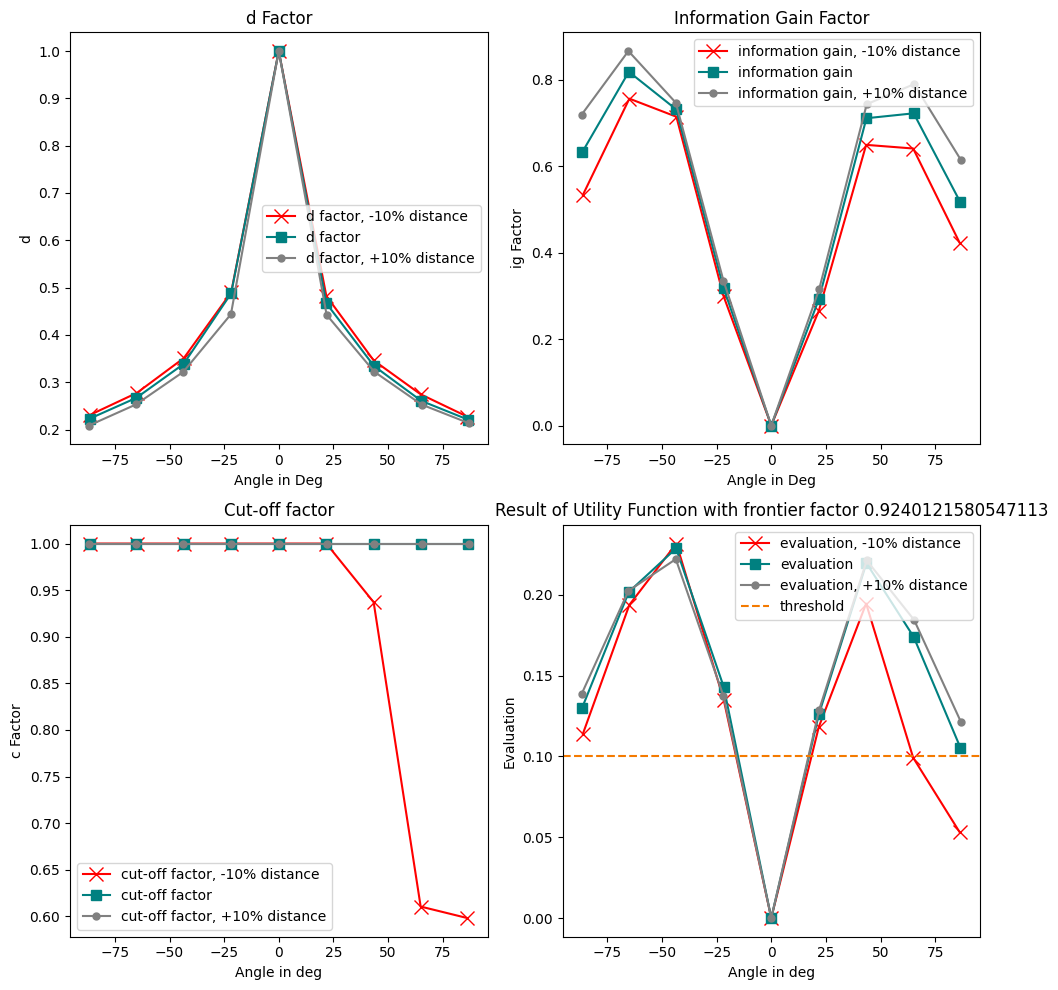

In [166]:
# Create a figure
plt.figure(figsize=(10, 10))

# First subplot
plt.subplot(2, 2, 1)
plt.plot(positions_d_close, d_factors_close, label='d factor, -10% distance', marker='x', color = 'red', markersize=10)
plt.plot(positions_d_mid, d_factors_mid, label='d factor', marker='s', color='teal', markersize=7.5)
plt.plot(positions_d_far, d_factors_far, label='d factor, +10% distance', marker='o', color='grey', markersize=5)
plt.title('d Factor')
plt.xlabel('Angle in Deg')
plt.ylabel('d')
plt.legend()

# Second subplot
plt.subplot(2, 2, 2)
plt.plot(positions_ig_close, ig_factors_close, label='information gain, -10% distance', marker='x', color = 'red', markersize=10)
plt.plot(positions_ig_mid, ig_factors_mid, label='information gain', marker='s', color='teal', markersize=7.5)
plt.plot(positions_ig_far, ig_factors_far, label='information gain, +10% distance', marker='o', color='grey', markersize=5)
plt.title('Information Gain Factor')
plt.xlabel('Angle in Deg')
plt.ylabel('ig Factor')
plt.legend()

# Third subplot
plt.subplot(2, 2, 3)
plt.plot(positions_o_close, o_factors_close, label='cut-off factor, -10% distance', marker='x', color = 'red', markersize=10)
plt.plot(positions_o_mid, o_factors_mid, label='cut-off factor', marker='s', color='teal', markersize=7.5)
plt.plot(positions_o_far, o_factors_far, label='cut-off factor, +10% distance', marker='o', color='grey', markersize=5)
plt.title('Cut-off factor')
plt.xlabel('Angle in deg')
plt.ylabel('c Factor')
plt.legend()

# Forth subplot
plt.subplot(2, 2, 4)
plt.plot(positions_eval_close, eval_factors_close, label='evaluation, -10% distance', marker='x', color = 'red', markersize=10)
plt.plot(positions_eval_mid, eval_factors_mid, label='evaluation', marker='s', color='teal', markersize=7.5)
plt.plot(positions_eval_far, eval_factors_far, label='evaluation, +10% distance', marker='o', color='grey', markersize=5)
ax = plt.gca()
threshold_value = 0.1
ax.axhline(y=threshold_value, color='#f47a00', linestyle='--', label='threshold')
plt.title(f'Result of Utility Function with frontier factor {Y_f_mid[0]}')
plt.xlabel('Angle in deg')
plt.ylabel('Evaluation')
plt.legend()

# Display the plots
plt.tight_layout()
#plt.show()
plt.savefig(f"graphs/{object_name}_allinone_{number}")

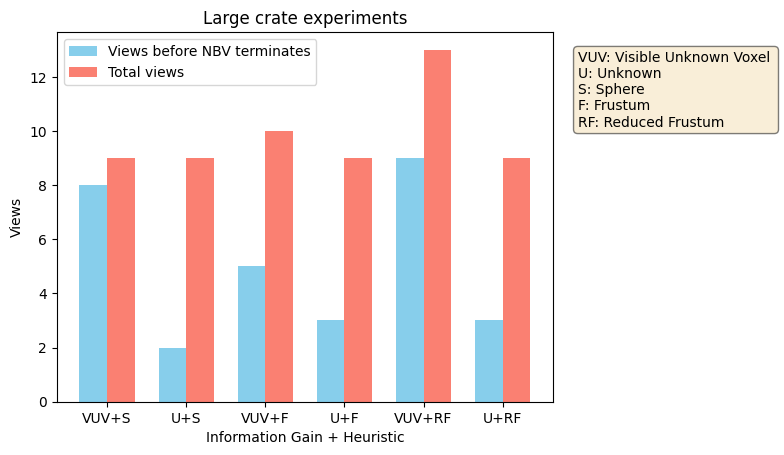

In [150]:

n_views = lambda x: len([v for v in x if v.time_loop != -1])
cat = ['VUV+S', 'U+S', 'VUV+F', 'U+F', 'VUV+RF', 'U+RF']
object_dict[object_name]["0"]["vuv"][0]
y_loop = [n_views(object_dict[object_name]["0"]["vuv"][0]), n_views(object_dict[object_name]["0"]["unknown"][0]),
          n_views(object_dict[object_name]["1"]["vuv"][0]), n_views(object_dict[object_name]["1"]["unknown"][0]),
          n_views(object_dict[object_name]["2"]["vuv"][0]), n_views(object_dict[object_name]["2"]["unknown"][0])]
y_views = [len(object_dict[object_name]["0"]["vuv"][0]), len(object_dict[object_name]["0"]["unknown"][0]),
           len(object_dict[object_name]["1"]["vuv"][0]), len(object_dict[object_name]["1"]["unknown"][0]),
           len(object_dict[object_name]["2"]["vuv"][0]), len(object_dict[object_name]["2"]["unknown"][0])]

x = np.arange(len(cat))  # array of positions for each category
width = 0.35



fig, ax = plt.subplots()

# Create bars for each dataset with an offset
bars1 = ax.bar(x - width/2, y_loop, width, label='Views before NBV terminates', color='skyblue')
bars2 = ax.bar(x + width/2, y_views, width, label='Total views', color='salmon')

# Add labels, title, and legend
ax.set_xlabel('Information Gain + Heuristic')
ax.set_ylabel('Views')
ax.set_title(f"{object_title} experiments")
ax.set_xticks(x)
ax.set_xticklabels(cat)
ax.legend()

ax.text(1.05, 0.95, "VUV: Visible Unknown Voxel \nU: Unknown \nS: Sphere \nF: Frustum \nRF: Reduced Frustum",
        transform=ax.transAxes,  # coordinates relative to the axes (0,0 is bottom left, 1,1 is top right)
        fontsize=10,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5)
       )

#plt.show()
plt.savefig(f"graphs/{object_name}_num_views.png", bbox_inches='tight')

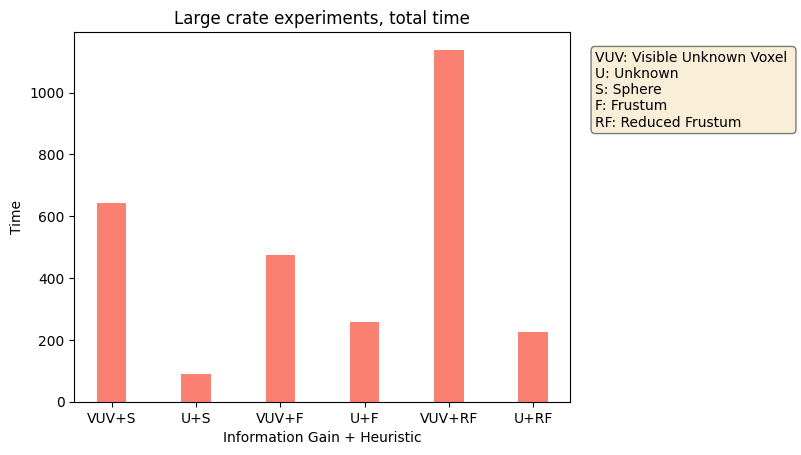

In [151]:
avg_time = lambda x: sum([v.time_loop for v in x if v.time_loop != -1]) / len([v.time_loop for v in x if v.time_loop != -1])
avg_time_per_frontier = lambda x: sum([v.time_loop / v.num_frontiers for v in x if v.max_candidate is not None]) / len([v.time_loop for v in x if v.max_candidate is not None])
cat = ['VUV+S', 'U+S', 'VUV+F', 'U+F', 'VUV+RF', 'U+RF']
y_loop = [avg_time(object_dict[object_name]["0"]["vuv"][0]), avg_time(object_dict[object_name]["0"]["unknown"][0]),
          avg_time(object_dict[object_name]["1"]["vuv"][0]), avg_time(object_dict[object_name]["1"]["unknown"][0]),
          avg_time(object_dict[object_name]["2"]["vuv"][0]), avg_time(object_dict[object_name]["2"]["unknown"][0])]
y_views = [object_dict[object_name]["0"]["vuv"][1], object_dict[object_name]["0"]["unknown"][1],
           object_dict[object_name]["1"]["vuv"][1], object_dict[object_name]["1"]["unknown"][1],
           object_dict[object_name]["2"]["vuv"][1], object_dict[object_name]["2"]["unknown"][1]]
y_loop_frontiers = [avg_time_per_frontier(object_dict[object_name]["0"]["vuv"][0]), avg_time_per_frontier(object_dict[object_name]["0"]["unknown"][0]),
                    avg_time_per_frontier(object_dict[object_name]["1"]["vuv"][0]), avg_time_per_frontier(object_dict[object_name]["1"]["unknown"][0]),
                    avg_time_per_frontier(object_dict[object_name]["2"]["vuv"][0]), avg_time_per_frontier(object_dict[object_name]["2"]["unknown"][0])]


x = np.arange(len(cat))  # array of positions for each category
width = 0.35

# Create the bar chart
plt.bar(cat, y_views, width= width, color='salmon')

# Add title and axis labels
plt.title(f'{object_title} experiments, total time')
plt.xlabel('Information Gain + Heuristic')
plt.ylabel('Time')
plt.text(1.05, 0.95, "VUV: Visible Unknown Voxel \nU: Unknown \nS: Sphere \nF: Frustum \nRF: Reduced Frustum",
        transform=plt.gca().transAxes,  # coordinates relative to the axes (0,0 is bottom left, 1,1 is top right)
        fontsize=10,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5)
       )
# Display the plot
#plt.show()
plt.savefig(f"graphs/{object_name}_total_times.png", bbox_inches='tight')



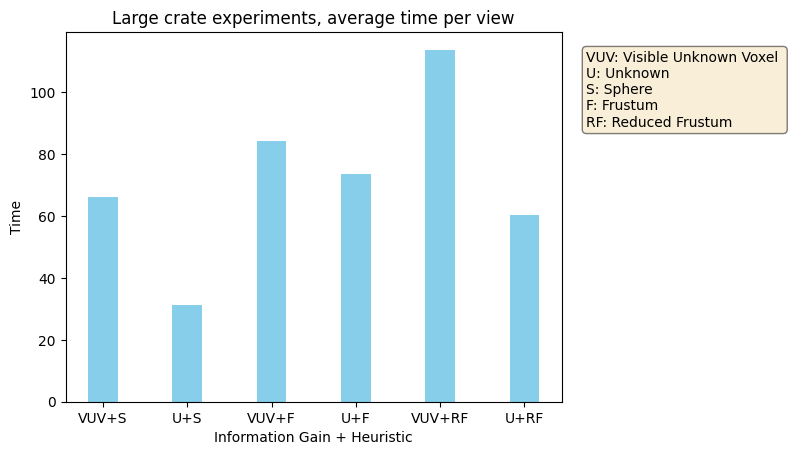

In [152]:
# Create the bar chart
plt.bar(cat, y_loop, width= width, color='skyblue')

# Add title and axis labels
plt.title(f'{object_title} experiments, average time per view')
plt.xlabel('Information Gain + Heuristic')
plt.ylabel('Time')

plt.text(1.05, 0.95, "VUV: Visible Unknown Voxel \nU: Unknown \nS: Sphere \nF: Frustum \nRF: Reduced Frustum",
        transform=plt.gca().transAxes,  # coordinates relative to the axes (0,0 is bottom left, 1,1 is top right)
        fontsize=10,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5)
       )
# Display the plot
#plt.show()
plt.savefig(f"graphs/{object_name}_avg_times.png", bbox_inches='tight')



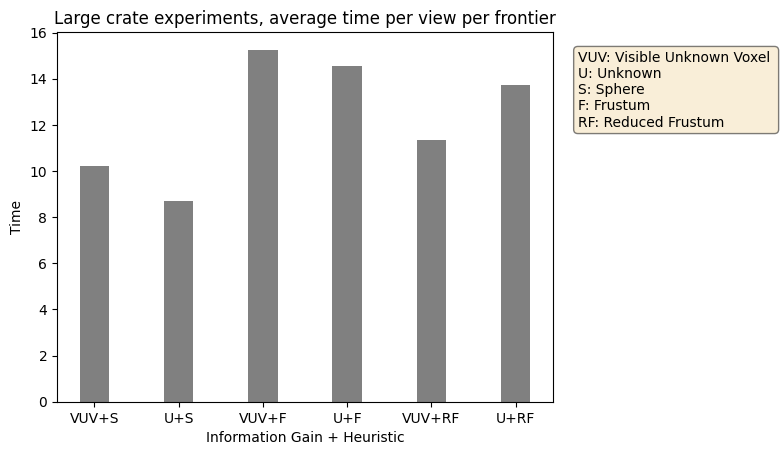

In [153]:

# Create the bar chart
plt.bar(cat, y_loop_frontiers, width= width, color='grey')

# Add title and axis labels
plt.title(f'{object_title} experiments, average time per view per frontier')
plt.xlabel('Information Gain + Heuristic')
plt.ylabel('Time')

plt.text(1.05, 0.95, "VUV: Visible Unknown Voxel \nU: Unknown \nS: Sphere \nF: Frustum \nRF: Reduced Frustum",
        transform=plt.gca().transAxes,  # coordinates relative to the axes (0,0 is bottom left, 1,1 is top right)
        fontsize=10,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5)
       )
# Display the plot
#plt.show()
plt.savefig(f"graphs/{object_name}_avg_times_frontiers.png", bbox_inches='tight')

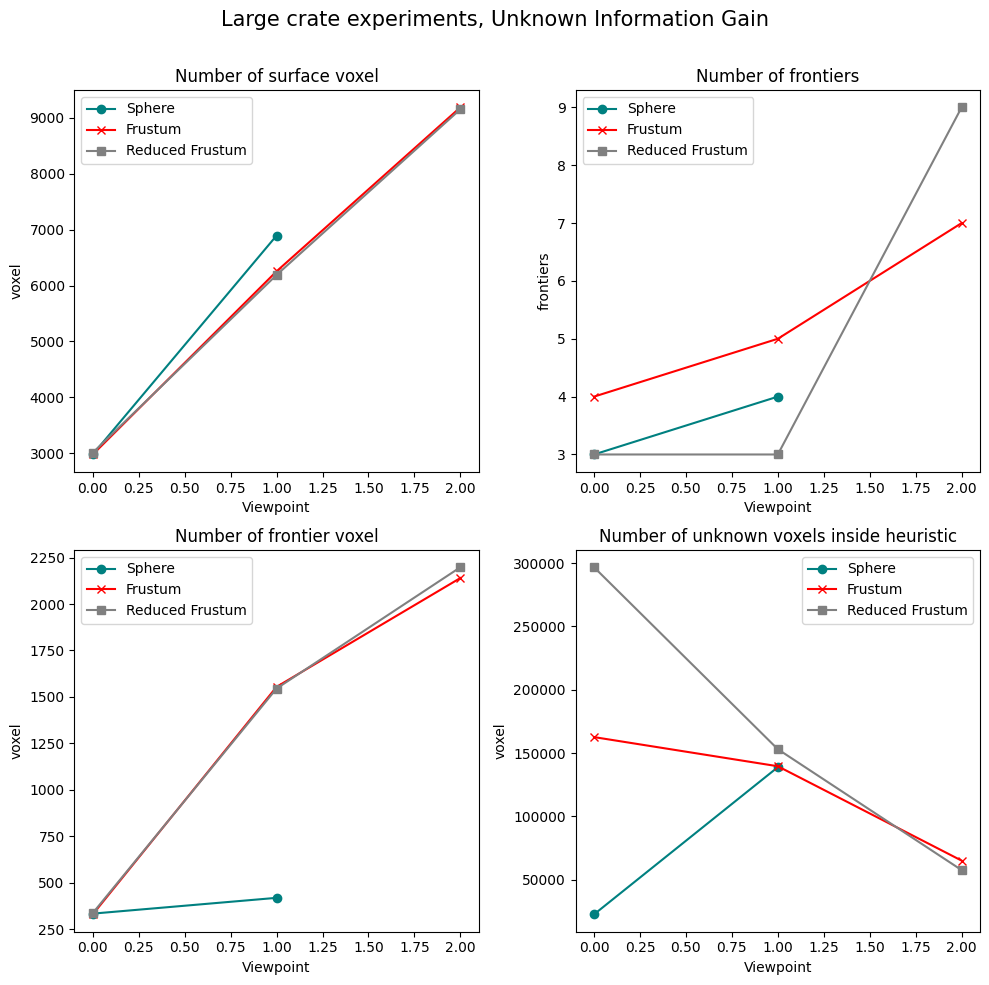

In [155]:
vuv = False
if vuv:
  l_0 = object_dict[object_name]["0"]["vuv"][0]
  l_1 = object_dict[object_name]["1"]["vuv"][0]
  l_2 = object_dict[object_name]["2"]["vuv"][0]
else:
  l_0 = object_dict[object_name]["0"]["unknown"][0]
  l_1 = object_dict[object_name]["1"]["unknown"][0]
  l_2 = object_dict[object_name]["2"]["unknown"][0]
base_0 = [v for v in l_0 if v.max_candidate is not None]
base_extra_0 = [v for v in l_0 if v.max_candidate is None and v.time_loop != -1]
base_1 = [v for v in l_1 if v.max_candidate is not None]
base_extra_1 = [v for v in l_1 if v.max_candidate is None and v.time_loop != -1]
base_2 = [v for v in l_2 if v.max_candidate is not None]
base_extra_2 = [v for v in l_2 if v.max_candidate is None and v.time_loop != -1]

# Create a figure
fig = plt.figure(figsize=(10, 10))

x_0 = np.arange(len(base_0))
if len(base_extra_0) != 0:
  x_0 = np.arange(len(base_0) + 1)

x_1 = np.arange(len(base_1))
if len(base_extra_1) != 0:
  x_1 = np.arange(len(base_1) + 1)

x_2 = np.arange(len(base_2))
if len(base_extra_2) != 0:
  x_2 = np.arange(len(base_2) + 1)


# First subplot
plt.subplot(2, 2, 1)
y_0 = [v.num_surface_vox for v in base_0]
if len(base_extra_0 ) != 0:
  y_0.append(base_extra_0[0].num_surface_vox)

y_1= [v.num_surface_vox for v in base_1]
if len(base_extra_1 ) != 0:
  y_1.append(base_extra_1[0].num_surface_vox)

y_2 = [v.num_surface_vox for v in base_2]
if len(base_extra_2 ) != 0:
  y_2.append(base_extra_2[0].num_surface_vox)

plt.plot(x_0, y_0, marker='o', label='Sphere', color='teal')
plt.plot(x_1, y_1, marker='x', label='Frustum', color='red')
plt.plot(x_2, y_2, marker='s', label='Reduced Frustum', color='grey')
plt.title('Number of surface voxel')
plt.xlabel('Viewpoint')
plt.ylabel('voxel')
plt.legend()

# Second subplot
plt.subplot(2, 2, 2)
y_0 = [v.num_frontiers for v in base_0]
if len(base_extra_0 ) != 0:
  y_0.append(0)
y_1= [v.num_frontiers for v in base_1]
if len(base_extra_1 ) != 0:
  y_1.append(0)
y_2 = [v.num_frontiers for v in base_2]
if len(base_extra_2 ) != 0:
  y_2.append(0)
plt.plot(x_0, y_0, marker='o', label='Sphere', color='teal')
plt.plot(x_1, y_1, marker='x', label='Frustum', color='red')
plt.plot(x_2, y_2, marker='s', label='Reduced Frustum', color='grey')
plt.title('Number of frontiers')
plt.xlabel('Viewpoint')
plt.ylabel('frontiers')
plt.legend()

# Third subplot
plt.subplot(2, 2, 3)
y_0 = [v.num_frontier_vox for v in base_0]
if len(base_extra_0 ) != 0:
  y_0.append(0)
y_1= [v.num_frontier_vox for v in base_1]
if len(base_extra_1 ) != 0:
  y_1.append(0)
y_2 = [v.num_frontier_vox for v in base_2]
if len(base_extra_2 ) != 0:
  y_2.append(0)
plt.plot(x_0, y_0, marker='o', label='Sphere', color='teal')
plt.plot(x_1, y_1, marker='x', label='Frustum', color='red')
plt.plot(x_2, y_2, marker='s', label='Reduced Frustum', color='grey')

plt.title('Number of frontier voxel')
plt.xlabel('Viewpoint')
plt.ylabel('voxel')
plt.legend()

# Forth subplot
plt.subplot(2, 2, 4)
y_0 = [v.num_unknown for v in base_0]
if len(base_extra_0 ) != 0:
  y_0.append(0)
y_1= [v.num_unknown for v in base_1]
if len(base_extra_1 ) != 0:
  y_1.append(0)
y_2 = [v.num_unknown for v in base_2]
if len(base_extra_2 ) != 0:
  y_2.append(0)
plt.plot(x_0, y_0, marker='o', label='Sphere', color='teal')
plt.plot(x_1, y_1, marker='x', label='Frustum', color='red')
plt.plot(x_2, y_2, marker='s', label='Reduced Frustum', color='grey')
if vuv:
  plt.title("Max number of visible unknown voxel seen")
else:
  plt.title("Number of unknown voxels inside heuristic")
plt.xlabel('Viewpoint')
plt.ylabel('voxel')
plt.legend()

# Display the plots
if vuv:
  fig.suptitle(f"{object_title} experiments, Visible Unknown Information Gain", fontsize=15)
else:
  fig.suptitle(f"{object_title} experiments, Unknown Information Gain", fontsize=15)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
if vuv:
  plt.savefig(f"graphs/{object_name}_3in1_vuv.png")
else:
  plt.savefig(f"graphs/{object_name}_3in1_unknown.png")

In [156]:
n_views = lambda x: len([v for v in x if v.time_loop != -1])
def avg_loop_views(ig, h):
  sum = 0
  for x in object_dict:
    sum += n_views(object_dict[x][f"{h}"][ig][0])
  return sum / len(object_dict)

def avg_views(ig, h):
  sum = 0
  for x in object_dict:
    sum += len(object_dict[x][f"{h}"][ig][0])
  return sum / len(object_dict)

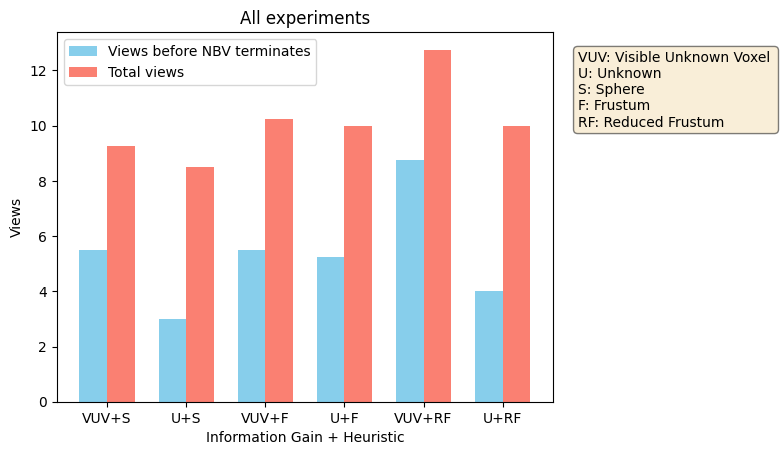

In [157]:

n_views = lambda x: len([v for v in x if v.time_loop != -1])
cat = ['VUV+S', 'U+S', 'VUV+F', 'U+F', 'VUV+RF', 'U+RF']

y_loop = [avg_loop_views("vuv", "0"), avg_loop_views("unknown", "0"),
          avg_loop_views("vuv", "1"), avg_loop_views("unknown", "1"),
          avg_loop_views("vuv", "2"), avg_loop_views("unknown", "2")]
y_views = [avg_views("vuv", "0"), avg_views("unknown", "0"),
           avg_views("vuv", "1"), avg_views("unknown", "1"),
           avg_views("vuv", "2"), avg_views("unknown", "2")]


x = np.arange(len(cat))  # array of positions for each category
width = 0.35

fig, ax = plt.subplots()

# Create bars for each dataset with an offset
bars1 = ax.bar(x - width/2, y_loop, width, label='Views before NBV terminates', color='skyblue')
bars2 = ax.bar(x + width/2, y_views, width, label='Total views', color='salmon')

# Add labels, title, and legend
ax.set_xlabel('Information Gain + Heuristic')
ax.set_ylabel('Views')
ax.set_title(f"All experiments")
ax.set_xticks(x)
ax.set_xticklabels(cat)
ax.legend()

ax.text(1.05, 0.95, "VUV: Visible Unknown Voxel \nU: Unknown \nS: Sphere \nF: Frustum \nRF: Reduced Frustum",
        transform=ax.transAxes,  # coordinates relative to the axes (0,0 is bottom left, 1,1 is top right)
        fontsize=10,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5)
       )

#plt.show()
plt.savefig("graphs/all_num_views.png", bbox_inches='tight')

VUV Sphere
Unknown Sphere
VUV Frustum
Unknown Frustum
VUV Reduced Frustum
Unknown Reduced Frustum


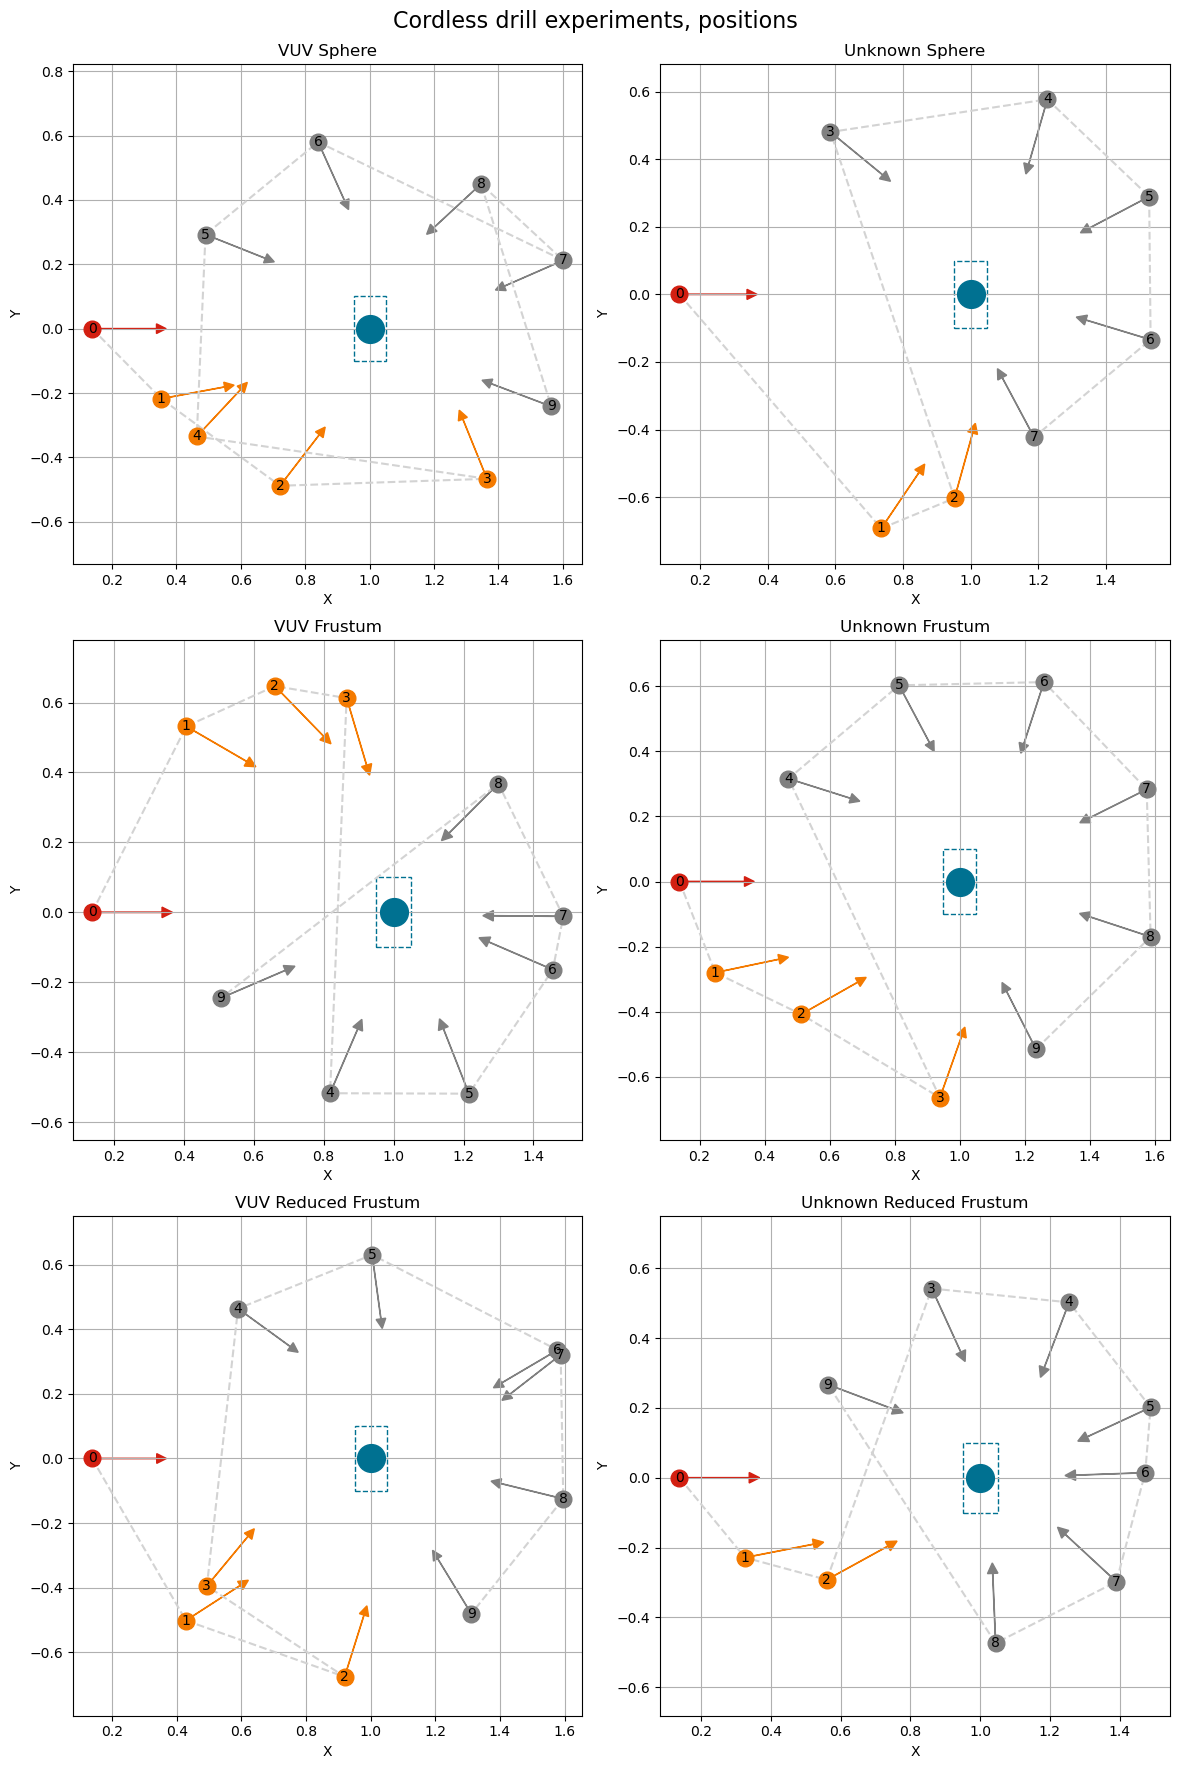

In [17]:
object_pos = {"drill": (1.0, 0.0, 0.1, 0.2), "bunny": (1.5, 0.0, 0.2, 0.4), "box": (1.0, 0.0, 0.1, 0.4), "crate": (3.0, 0.0, 2.0, 1.0)}
plt.figure(figsize=(12, 18))
arrow_length = 0.2
for h in ['0', '1', '2']:
  for ig in ['vuv', 'unknown']:
    lines = object_dict[object_name][f"{h}"][ig][0]
    if ig == 'vuv':
      plt.subplot(3, 2, int(h) * 2 + 1)
    else:
      plt.subplot(3, 2, int(h) * 2 + 2)
    X = [p.pose.position.x for p in lines]
    Y = [p.pose.position.y for p in lines]
    plt.plot(X,Y, color='lightgrey', linestyle='--')
    for i in range(0, len(lines)):
      _,_,yaw = quaternion_to_euler_2(lines[i].pose.orientation)
      dx = np.cos(yaw) * arrow_length
      dy = np.sin(yaw) * arrow_length
      x, y = lines[i].pose.position.x, lines[i].pose.position.y
      if i == 0:
        plt.plot(x,y,'o', color='#d31f11', markersize=12)
        plt.arrow(x, y, dx, dy, head_width=0.03, head_length=0.03, fc='#d31f11', ec='#d31f11')
      elif lines[i].time_loop == -1:
        plt.plot(x,y,'o', color='grey', markersize=12)
        plt.arrow(x, y, dx, dy, head_width=0.03, head_length=0.03, fc='grey', ec='grey')
      else:
        plt.plot(x,y,'o', color='#f47a00', markersize=12)
        plt.arrow(x, y, dx, dy, head_width=0.03, head_length=0.03, fc='#f47a00', ec='#f47a00')
      plt.text(x, y, f'{i}'.format(), fontsize=10, ha='center', va='center')


    x,y,w,l = object_pos[object_name]
    plt.plot(x,y, 'o', markersize=20, color='#007191')
    ax = plt.gca()
    rect = patches.Rectangle((x - w/2.0,y - l/2.0),w,l, linewidth=1, edgecolor='#007191', facecolor='none', linestyle='--')
    ax.add_patch(rect)
    plt.xlabel('X')
    plt.ylabel('Y')
    dict_title = {"vuv": {'0': "VUV Sphere", '1': "VUV Frustum", '2': "VUV Reduced Frustum"}, 
                  "unknown": {'0': "Unknown Sphere", '1': "Unknown Frustum", '2': "Unknown Reduced Frustum"}}
    print(dict_title[ig][h])
    plt.title(dict_title[ig][h])
    plt.grid(True)
    plt.axis('equal')
#plt.show()

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.suptitle(f"{object_title} experiments, positions", fontsize=16)
plt.savefig(f"graphs/{object_name}_all_views.png")


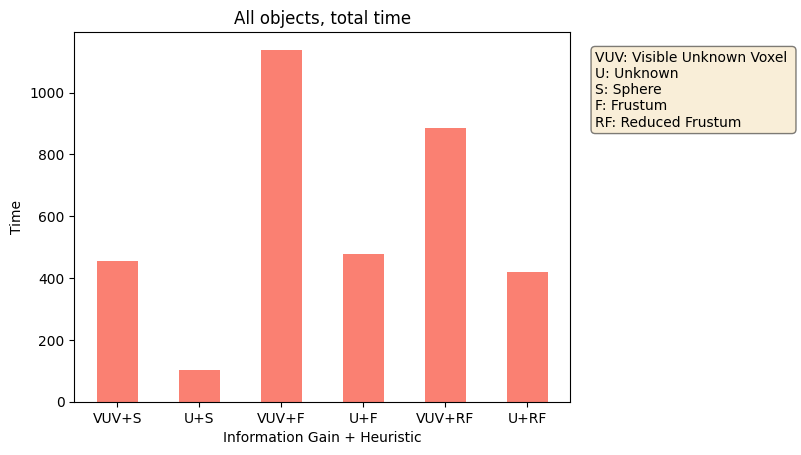

In [75]:
avg_time = lambda x: sum([v.time_loop for v in x if v.time_loop != -1]) / len([v.time_loop for v in x if v.time_loop != -1])
avg_time_per_frontier = lambda x: sum([v.time_loop / v.num_frontiers for v in x if v.max_candidate is not None]) / len([v.time_loop for v in x if v.max_candidate is not None])

def avg_times(ig, h):
  sum = 0
  for x in object_dict:
    sum += avg_time(object_dict[x][f"{h}"][ig][0])
  return sum / len(object_dict)

def avg_times_per_frontier(ig, h):
  sum = 0
  for x in object_dict:
    sum += avg_time_per_frontier(object_dict[x][f"{h}"][ig][0])
  return sum / len(object_dict)

def avg_total_times(ig, h):
  sum = 0
  for x in object_dict:
    sum += object_dict[x][f"{h}"][f"{ig}"][1]
  return sum / len(object_dict)


cat = ['VUV+S', 'U+S', 'VUV+F', 'U+F', 'VUV+RF', 'U+RF']
y_loop = [avg_times("vuv", "0"), avg_times("unknown", "0"),
          avg_times("vuv", "1"), avg_times("unknown", "1"),
          avg_times("vuv", "2"), avg_times("unknown", "2")]
y_views = [avg_total_times("vuv", "0"), avg_total_times("unknown", "0"),
           avg_total_times("vuv", "1"), avg_total_times("unknown", "1"),
           avg_total_times("vuv", "2"), avg_total_times("unknown", "2")]
y_loop_frontiers = [avg_times_per_frontier("vuv", "0"), avg_times_per_frontier("unknown", "0"),
                    avg_times_per_frontier("vuv", "1"), avg_times_per_frontier("unknown", "1"),
                    avg_times_per_frontier("vuv", "2"), avg_times_per_frontier("unknown", "2")]


x = np.arange(len(cat))  # array of positions for each category
width=0.5

# Create the bar chart
plt.bar(cat, y_views, width=width, color='salmon')

# Add title and axis labels
plt.title(f'All objects, total time')
plt.xlabel('Information Gain + Heuristic')
plt.ylabel('Time')
plt.text(1.05, 0.95, "VUV: Visible Unknown Voxel \nU: Unknown \nS: Sphere \nF: Frustum \nRF: Reduced Frustum",
        transform=plt.gca().transAxes,  # coordinates relative to the axes (0,0 is bottom left, 1,1 is top right)
        fontsize=10,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.savefig("graphs/all_total_times.png", bbox_inches='tight')


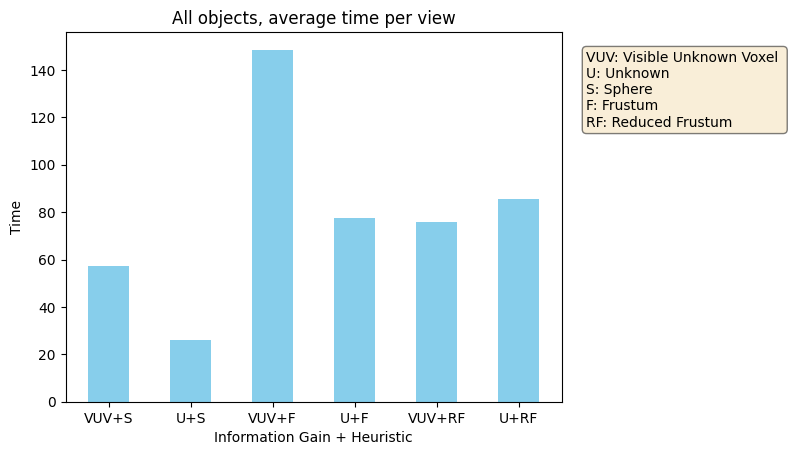

In [76]:

# Create the bar chart
plt.bar(cat, y_loop, width= width, color='skyblue')

# Add title and axis labels
plt.title(f'All objects, average time per view')
plt.xlabel('Information Gain + Heuristic')
plt.ylabel('Time')
plt.text(1.05, 0.95, "VUV: Visible Unknown Voxel \nU: Unknown \nS: Sphere \nF: Frustum \nRF: Reduced Frustum",
        transform=plt.gca().transAxes,  # coordinates relative to the axes (0,0 is bottom left, 1,1 is top right)
        fontsize=10,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
plt.savefig("graphs/all_avg_times.png", bbox_inches='tight')


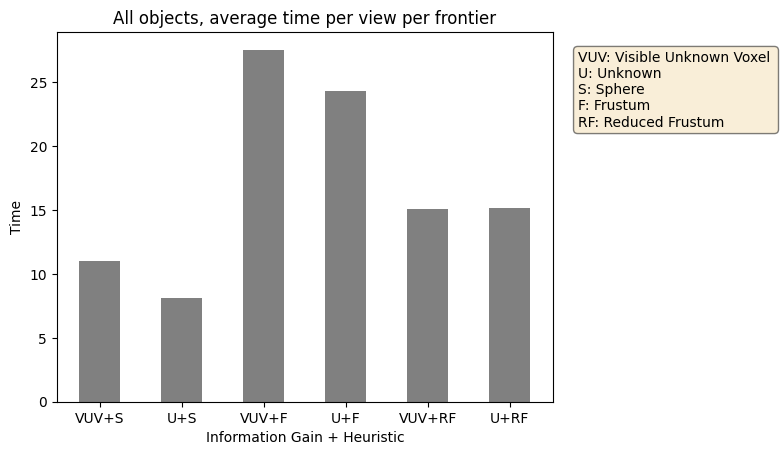

In [77]:


# Create the bar chart
plt.bar(cat, y_loop_frontiers, width= width, color='grey')

# Add title and axis labels
plt.title(f'All objects, average time per view per frontier')
plt.xlabel('Information Gain + Heuristic')
plt.ylabel('Time')

plt.text(1.05, 0.95, "VUV: Visible Unknown Voxel \nU: Unknown \nS: Sphere \nF: Frustum \nRF: Reduced Frustum",
        transform=plt.gca().transAxes,  # coordinates relative to the axes (0,0 is bottom left, 1,1 is top right)
        fontsize=10,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5)
       )
# Display the plot
#plt.show()
plt.savefig("graphs/all_avg_times_frontiers.png", bbox_inches='tight')